# NLP

In [11]:
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt

import torch

from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split

In [12]:
df_copom = pd.read_csv('df_copom_label_pt.csv')

In [13]:
df_copom.head(1)

,meeting_number,date_x,date_y,selic,decision,decision_txt,type,text,num_words,text_raw,num_words_raw,label_hawk_dove,label_next_meet
0,21,1998/01/28,1998/01/28,34.5,-3.5,cortar,minutes,sumáriopreços nível atividade agregados monetá...,3926.0,\nSumárioPreços e Nível de Atividade\nAgregado...,5066.0,dovish,cortar


In [14]:
df_copom.shape

(411, 13)

In [15]:
df_ = df_copom[(df_copom['type'] == 'statement')].copy()

In [16]:
df_.shape

(209, 13)

In [17]:
# df_ = df_[(df_['num_words'] <= 250)].copy()

In [18]:
# df_.shape

In [19]:
df_['num_words'].unique()

array([ 51.,  15.,  29.,  23.,  17.,   2.,  12.,  19.,  21.,  18.,  28.,
        22.,  55.,  25.,  26.,  14.,  16.,  20.,  34.,  44.,  42.,  31.,
        24.,  33.,  45.,  35.,  38.,  27.,  30.,  61.,  80.,  53.,  46.,
        60.,  58.,  40.,  43.,  52.,  36.,  69.,  73.,  78.,  49.,  32.,
        47.,  66.,  90.,  37.,  70., 218.,  57.,  41., 102., 109., 103.,
       122., 126., 125.,  48.,  86.,  99.,  98., 260., 405., 483., 450.,
       476., 350., 466., 416., 414., 481., 467., 499., 473., 540., 609.,
       620., 553., 602., 497., 528., 557., 508., 524., 549., 581., 522.,
       503., 458., 583., 550., 621., 701., 669., 733., 703., 596., 627.,
       653., 690., 533., 665., 643., 634., 518., 532., 520., 606., 469.])

<Axes: >

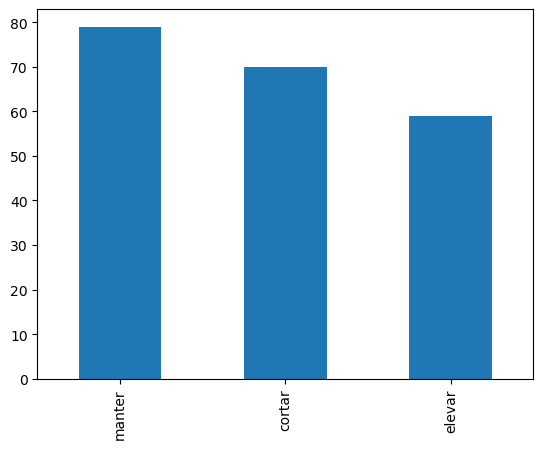

In [20]:
df_['label_next_meet'].value_counts().plot(kind='bar')

In [21]:
target_map = {'cortar': 0, 'elevar': 1, 'manter': 2}
df_['target'] = df_['label_next_meet'].map(target_map)

In [22]:
df = df_[['text', 'target']]
df.columns = ['sentence', 'label']

In [23]:
df

,sentence,label
25,pese recentes trajetórias favoráveis taxas inf...,2.0
27,copom analisando eventos recentes prospectivos...,0.0
29,resultados recentes inflação mudaram significa...,0.0
31,"copom decidiu alterar meta taxa selic 17,0 % 1...",2.0
33,"copom decidiu manter meta taxa selic 16,50 % e...",2.0
...,...,...
401,"250ª reunião , comitê política monetária ( cop...",2.0
404,"251ª reunião , comitê política monetária ( cop...",2.0
405,"252ª reunião , comitê política monetária ( cop...",2.0
407,desde reunião anterior comitê política monetár...,2.0


In [24]:
df.isnull().sum()

sentence    0
label       1
dtype: int64

In [25]:
df = df.dropna().copy()
df.shape

(208, 2)

In [26]:
df['label'] = df['label'].astype(int)

In [27]:
df.head()

,sentence,label
25,pese recentes trajetórias favoráveis taxas inf...,2
27,copom analisando eventos recentes prospectivos...,0
29,resultados recentes inflação mudaram significa...,0
31,"copom decidiu alterar meta taxa selic 17,0 % 1...",2
33,"copom decidiu manter meta taxa selic 16,50 % e...",2


In [28]:
df.to_csv('data_copom_transf_pt_nextmeet.csv', index=None)

#### Convert to dataset

In [29]:
from datasets import load_dataset

raw_dataset = load_dataset('csv', data_files='data_copom_transf_pt_nextmeet.csv')

Extracting data files: 100%|████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 125.01it/s]


Dataset csv downloaded and prepared to C:/Users/ftrav/.cache/huggingface/datasets/csv/default-c770718218b0ff5d/0.0.0/eea64c71ca8b46dd3f537ed218fc9bf495d5707789152eb2764f5c78fa66d59d. Subsequent calls will reuse this data.


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 90.89it/s]


In [30]:
raw_dataset

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label'],
        num_rows: 208
    })
})

#### Split test and train

In [31]:
split = raw_dataset['train'].train_test_split(test_size=0.3, seed=2015)

In [32]:
split

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label'],
        num_rows: 145
    })
    test: Dataset({
        features: ['sentence', 'label'],
        num_rows: 63
    })
})

## Model

In [33]:
# from transformers import AutoTokenizer, AutoModelForSequenceClassification¶
# tokenizer = AutoTokenizer.from_pretrained("TiagoSanti/bert-base-portuguese-cased-02")
# model = AutoModelForSequenceClassification.from_pretrained("TiagoSanti/bert-base-portuguese-cased-02")

https://huggingface.co/TiagoSanti/bert-base-portuguese-cased-02

In [34]:
checkpoint = 'TiagoSanti/bert-base-portuguese-cased-02'

#### Tokenizer

In [35]:
from transformers import AutoTokenizer

In [36]:
max_length = 512

In [37]:
tokenizer = AutoTokenizer.from_pretrained(checkpoint, do_lower_case=True, padding=True)

# 'longest_first'

In [38]:
def tokenize_fn(batch):
    return tokenizer(batch['sentence'], max_length=512, truncation=True, padding=True) 

#, truncation='longest_first', padding=True)

In [39]:
tokenized_datasets = split.map(tokenize_fn, batched=True)

In [40]:
tokenized_datasets

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 145
    })
    test: Dataset({
        features: ['sentence', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 63
    })
})

In [41]:
tokenized_datasets.set_format()

#### Training

In [42]:
from transformers import AutoModelForSequenceClassification, Trainer, TrainingArguments

In [43]:
model = AutoModelForSequenceClassification.from_pretrained(checkpoint, max_length=max_length)

In [44]:
from torchinfo import summary

In [45]:
summary(model)

Layer (type:depth-idx)                                  Param #
BertForSequenceClassification                           --
├─BertModel: 1-1                                        --
│    └─BertEmbeddings: 2-1                              --
│    │    └─Embedding: 3-1                              22,881,792
│    │    └─Embedding: 3-2                              393,216
│    │    └─Embedding: 3-3                              1,536
│    │    └─LayerNorm: 3-4                              1,536
│    │    └─Dropout: 3-5                                --
│    └─BertEncoder: 2-2                                 --
│    │    └─ModuleList: 3-6                             85,054,464
│    └─BertPooler: 2-3                                  --
│    │    └─Linear: 3-7                                 590,592
│    │    └─Tanh: 3-8                                   --
├─Dropout: 1-2                                          --
├─Linear: 1-3                                           2,307
Total params: 10

In [46]:
def compute_metrics(logits_and_labels):
    logits, labels = logits_and_labels
    predictions = np.argmax(logits, axis=-1)
    acc = np.mean(predictions == labels)
    f1 = f1_score(labels, predictions, average='macro')
    return {'accuracy': acc, 'f1': f1}

In [47]:
training_args = TrainingArguments(
    output_dir='training_dir/pt/nextmeet',
    evaluation_strategy='epoch',
    save_strategy='epoch',
    num_train_epochs=5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size= 64
)

In [48]:
trainer = Trainer(
    model,
    training_args,
    train_dataset=tokenized_datasets['train'],
    eval_dataset=tokenized_datasets['test'],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

In [60]:
trainer.train()

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.812170,0.650794,0.603357
2,No log,0.678407,0.730159,0.727403
3,No log,0.698158,0.746032,0.744403
4,No log,0.741253,0.761905,0.760132
5,No log,0.722034,0.746032,0.744403


TrainOutput(global_step=50, training_loss=0.7638151550292969, metrics={'train_runtime': 675.4284, 'train_samples_per_second': 1.073, 'train_steps_per_second': 0.074, 'total_flos': 190757227852800.0, 'train_loss': 0.7638151550292969, 'epoch': 5.0})

In [62]:
!dir training_dir\pt\nextmeet

 Volume in drive C has no label.
 Volume Serial Number is 5AAA-7C2A

 Directory of C:\Users\ftrav\Documents\Insper_tcc\training_dir\pt\nextmeet

07/02/2023  06:00 PM    <DIR>          .
07/02/2023  05:29 PM    <DIR>          ..
07/02/2023  05:51 PM    <DIR>          checkpoint-10
07/02/2023  05:54 PM    <DIR>          checkpoint-20
07/02/2023  05:56 PM    <DIR>          checkpoint-30
07/02/2023  05:58 PM    <DIR>          checkpoint-40
07/02/2023  06:00 PM    <DIR>          checkpoint-50
07/02/2023  05:49 PM    <DIR>          runs
               0 File(s)              0 bytes
               8 Dir(s)   6,162,026,496 bytes free


#### Test

In [1]:
from transformers import pipeline, AutoConfig

C:\Users\ftrav\anaconda3\envs\tcc_gpu2\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [9]:
config = AutoConfig.from_pretrained(checkpoint)

In [10]:
savedmodel = pipeline('text-classification',
                      model='training_dir/pt/nextmeet/checkpoint-50',
                      max_length=max_length,
                      tokenizer=tokenizer, 
                      config=config,
                      device=0,
                      framework="pt")

Xformers is not installed correctly. If you want to use memory_efficient_attention to accelerate training use the following command to install Xformers
pip install xformers.


In [49]:
split['test']

Dataset({
    features: ['sentence', 'label'],
    num_rows: 63
})

In [50]:
test_pred = savedmodel(split['test']['sentence'], batch_size=128, truncation="longest_first")

In [51]:
for i in range(len(split['test']['label'])):
    print (split['test']['label'][i], test_pred[i])

2 {'label': 'LABEL_2', 'score': 0.8472135066986084}
0 {'label': 'LABEL_0', 'score': 0.9768586754798889}
0 {'label': 'LABEL_0', 'score': 0.9769091010093689}
2 {'label': 'LABEL_2', 'score': 0.860059916973114}
1 {'label': 'LABEL_1', 'score': 0.8888346552848816}
1 {'label': 'LABEL_1', 'score': 0.8790423274040222}
0 {'label': 'LABEL_0', 'score': 0.97142493724823}
0 {'label': 'LABEL_0', 'score': 0.9716176986694336}
0 {'label': 'LABEL_0', 'score': 0.9358140230178833}
2 {'label': 'LABEL_2', 'score': 0.8192464709281921}
0 {'label': 'LABEL_0', 'score': 0.9713959097862244}
2 {'label': 'LABEL_2', 'score': 0.8714019060134888}
0 {'label': 'LABEL_2', 'score': 0.8542435169219971}
0 {'label': 'LABEL_0', 'score': 0.9774821400642395}
1 {'label': 'LABEL_2', 'score': 0.8194291591644287}
1 {'label': 'LABEL_1', 'score': 0.7344809174537659}
0 {'label': 'LABEL_0', 'score': 0.8978084921836853}
1 {'label': 'LABEL_2', 'score': 0.8782287836074829}
0 {'label': 'LABEL_0', 'score': 0.970583975315094}
1 {'label': 'LAB

#### Graph

In [52]:
def get_label(d):
    return int(d['label'].split('_')[1])

test_pred = [get_label(d) for d in test_pred]

In [53]:
print("acc:", accuracy_score(split['test']['label'], test_pred))

acc: 0.746031746031746


In [54]:
print("f1:", f1_score(split['test']['label'], test_pred, average='macro'))

f1: 0.7444030597941448


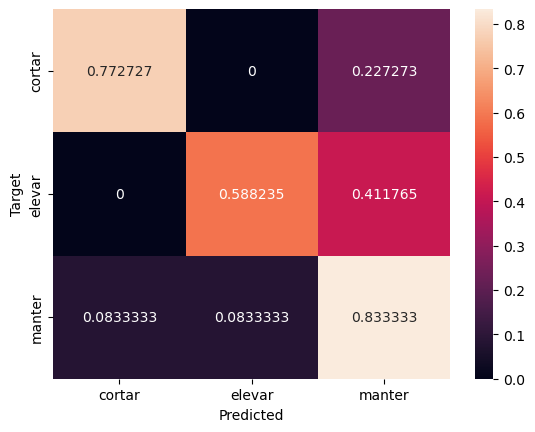

In [55]:
# Scikit-Learn is transitioning to V1 but it's not available on Colab
# The changes modify how confusion matrices are plotted
def plot_cm(cm):
    classes = ['cortar', 'elevar', 'manter']
    df_cm = pd.DataFrame(cm, index=classes, columns=classes)
    ax = sn.heatmap(df_cm, annot=True, fmt='g')
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Target")

cm = confusion_matrix(split['test']['label'], test_pred, normalize='true')
plot_cm(cm)